### COMPLETE REGION KPI CALCULATION

Function that can be looped through a folder with all the instance classified as 3 folders for each region. Running time is fast, just 6 seconds for one region (including creating pickle files)

Trial is made with Warmsen data which is almos complete except for Monday. 

The paths in this code are with respect to my machine station file system, please change paths to test.

In [103]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import pickle
import scipy
import seaborn as sns

In [104]:
#Define your default path where the samples are located as a CSV file
path_samples_equal = r'C:\Users\julli\OneDrive\Escritorio\DP_DATA_TEST\KPI_Test2_Data\CSV_Files\Equal'
path_samples_unequal = r'C:\Users\julli\OneDrive\Escritorio\DP_DATA_TEST\KPI_Test2_Data\CSV_Files\Unequal'

#Define your path to save KPI files
path_storage_equal = r'C:\Users\julli\OneDrive\Escritorio\DP_DATA_TEST\KPI_Test2_Data\Results\Equal Results'
path_storage_unequal = r'C:\Users\julli\OneDrive\Escritorio\DP_DATA_TEST\KPI_Test2_Data\Results\Unequal Results'

In [105]:
#Funtions that calculates KPI for a specific subset of DF needed (or specific instance) and stores all needed results

def KPI_calculation(sample_df):
    
    #Indicate the name of the columns on the KPI table
    KPI_columns = ['N',
               'Avg Shipment per district',
               'Touching Rate',
               'Drop Factor',
               'Avg Distance DP',
               'Avg Distance Solver',
               'Avg Distance Recalc',
               'Cost Improvement % Recalc vs DP',
               'Cost Improvement % Recalc vs Solver',
               'Similarity % Solver/DP',
               'Similarity % Recalc/DP',
               'Similarity % Recalc/Solver']

    #Expanding() function is used to average all columns calculations with respect to the sample number and the aggregate of the previous values until N 

    #Create Dataframe
    df_KPI = pd.DataFrame(columns = KPI_columns)

    #Fill n values
    df_KPI['N'] = sample_df.iloc[:,5]

    #Fill average shipment per district
    df_KPI['Avg Shipment per district'] = sample_df.iloc[:,9].expanding().mean().round(2)

    #Fill touching Rate 
    df_KPI['Touching Rate'] = (sample_df.iloc[:,10]/sample_df.iloc[:,11]).expanding().mean().round(3)

    #Fill Drop Factor

    df_KPI['Drop Factor'] = (sample_df.iloc[:,9]/sample_df.iloc[:,10]).expanding().mean().round(3)

    #Fill Average Distances (DP Sequence, Solver Sequence, Recalculation)
    df_KPI['Avg Distance DP'] = sample_df.iloc[:,12].expanding().mean().round(2)
    df_KPI['Avg Distance Solver'] = sample_df.iloc[:,13].expanding().mean().round(2)
    df_KPI['Avg Distance Recalc'] = sample_df.iloc[:,14].expanding().mean().round(2)

    #Fill Cost Improvements
    df_KPI['Cost Improvement % Recalc vs DP'] = ((sample_df.iloc[:,12]-sample_df.iloc[:,14])*100/sample_df.iloc[:,14]).expanding().mean().round(2)
    df_KPI['Cost Improvement % Recalc vs Solver'] = ((sample_df.iloc[:,13]-sample_df.iloc[:,14])*100/sample_df.iloc[:,14]).expanding().mean().round(2)

    #Fill Average Similarities
    df_KPI['Similarity % Solver/DP'] = sample_df.iloc[:,17].expanding().mean().round(2)
    df_KPI['Similarity % Recalc/DP'] = sample_df.iloc[:,16].expanding().mean().round(2)
    df_KPI['Similarity % Recalc/Solver'] = sample_df.iloc[:,15].expanding().mean().round(2)

    #Create a dictionary for every column in the KPI table
    dict_KPI =  {col: df_KPI[col].tolist() for col in df_KPI}

    #Store last row KPIs which corresponds to max N value for future averages
    converged_values = df_KPI.tail(1).reset_index(drop = True)
    
    

    return dict_KPI, converged_values

In [106]:
#Function to generate a unified complete dataframe for the regions instances and their samples

def get_complete_region(path_csv, region_name):

    dfs = []

    file_path_region = os.path.join(path_csv, region_name)
    files = os.listdir(file_path_region)

    # Iterate through each file in the folder
    for filename in files:
        if filename.endswith('.csv'):
            # Construct the full file path
            file_path = os.path.join(file_path_region, filename)
            
            # Read the CSV file into a dataframe
            df = pd.read_csv(file_path)
            
            # Append the dataframe to the list
            dfs.append(df)

    # Concatenate all dataframes into a single dataframe
    df_region_complete = pd.concat(dfs, ignore_index=True) 

    return df_region_complete

In [107]:
#Function to generate the dataframe for the statiscs for a specific region based on last value of N of each instance 
# and creates a folder to store all the picke files containing the complete sample info

def get_region_statistics(save_path, region_data_df, region_name):

     
    #Define folder location of the pickle files of each instance combination and its samples
    dir_KPI = os.path.join(save_path, region_name +'_KPI_Samples')
    if not os.path.exists(dir_KPI):
        os.mkdir(dir_KPI)
    
    #Define the columns for the statistics dataframe for each region
    Region_KPI_columns = ['Shipment Level',
                        'Avg Shipment per district',
                        'Touching Rate',
                        'Drop Factor',
                        'Avg Distance DP',
                        'Avg Distance Solver',
                        'Avg Distance Recalc',
                        'Cost Improvement % Recalc vs DP',
                        'Cost Improvement % Recalc vs Solver',
                        'Similarity % Solver/DP',
                        'Similarity % Recalc/DP',
                        'Similarity % Recalc/Solver']
    

    #Generate an empty dataframe of the region with the column names for the KPIs
    Region_KPI_df = pd.DataFrame(columns = Region_KPI_columns)

    #Loop through the table separating in subset of dataframes needed without repetition. 
    # Assure that region is first level for naming of the files
    region_list = region_data_df['Region'].unique().tolist()
    for region in region_list: 
        #This separation is relevant since per level of shipment is where the converged values of the KPIs will be then stored and averaged in a row to be filled in the final table
        shipment_levels_list = region_data_df.iloc[:,4].unique().tolist()   #Separating by shipment level or scenario type
        for level in shipment_levels_list: 
            row_level = pd.DataFrame()
            df_A = region_data_df[region_data_df.iloc[:,4] == level]
            district_list = df_A['District'].unique().tolist()
            for district in district_list: 
                    df_B = df_A[df_A['District'] == district]
                    day_list = df_B['Day'].unique().tolist()
                    for day in day_list: 
                        df_C = df_B[df_B['Day'] == day]

                        #Final level of a unique instance. Compute the KPI sample and obtain the converged values
                        KPI_info, last_value = KPI_calculation(df_C)
                        pickle.dump(KPI_info, open(os.path.join(dir_KPI, 'KPI_' + region + '_' + district + '_'+ day + '_' + str(level) + '.p'), 'wb'))
                        row_level = pd.concat([row_level, last_value], ignore_index=True)

            #row_level = row_level.rename(columns={'N': 'Shipment Level'})
            row_level.drop(columns=row_level.columns[0], axis=1,  inplace=True)
            #row_level['Shipment Level'] = level

            level_average = row_level.mean().round(2).to_frame().transpose()
            level_average.insert(0, "Shipment Level", level)

            Region_KPI_df = pd.concat([Region_KPI_df, level_average], ignore_index=True)
        

    return Region_KPI_df

In [108]:
#Pipeline which just recieves the paths of files and the region name and computes the table and stores files.

def pipeline_statistics_region(path_csv_files, path_KPI_storage, specific_region):
    
    df_complete_region = get_complete_region(path_csv = path_csv_files, region_name = specific_region)

    dir_KPI = os.path.join(path_KPI_storage, specific_region +'_KPI_Complete_CSV')
    if not os.path.exists(dir_KPI):
        os.mkdir(dir_KPI)

    csv_name = specific_region + 'KPI_complete_csv'

    df_complete_region.to_csv(os.path.join(dir_KPI, csv_name), index = False)

    Table_KPI_region = get_region_statistics(save_path = path_KPI_storage, region_data_df = df_complete_region, region_name = specific_region)

    return Table_KPI_region 

In [109]:
#Function to PLOT EQUAL SHIPMENTS the KPI with respect to the Shipment Level as independent variable. 

def KPI_region_equal_plots(Region_KPI_df):

    #Extract the data from the DataFrame
    #Extract the X label of the shipment levels use for all graphs
    x = Region_KPI_df.iloc[:, 0] 

    #Extract every KPI as a y axis for plotting 
    y1 = Region_KPI_df.iloc[:, 1]
    y2 = Region_KPI_df.iloc[:, 2]
    y3 = Region_KPI_df.iloc[:, 3]
    y4 = Region_KPI_df.iloc[:, 4]
    y5 = Region_KPI_df.iloc[:, 5]
    y6 = Region_KPI_df.iloc[:, 6]
    y7 = Region_KPI_df.iloc[:, 7]
    y8 = Region_KPI_df.iloc[:, 8]
    y9 = Region_KPI_df.iloc[:, 9]
    y10 = Region_KPI_df.iloc[:, 10]
    y11 = Region_KPI_df.iloc[:, 11]

    
    # Set the style of the plot
    sns.set(style="darkgrid")

    # Create two separate line plots
    plt.figure(figsize=(25, 18))

    plt.subplot(3, 2, 1)
    plt.plot(x, y1, marker='o')
    plt.xlabel('Volume')
    plt.ylabel('Avg Shipment per District')
 

    plt.subplot(3, 2, 2)
    plt.plot(x, y2, marker='o')
    plt.xlabel('Volume')
    plt.ylabel('Touching Rate')

    plt.subplot(3, 2, 3)
    plt.plot(x, y3, marker='o')
    plt.xlabel('Volume')
    plt.ylabel('Drop Factor')


    plt.subplot(3, 2, 4)
    plt.plot(x, y4, marker='o', label='DP Sequence')
    plt.plot(x, y5, marker='o', label='Solver Sequence')
    plt.plot(x, y6, marker='o', label='Recalculated', linestyle='dashed')
    plt.legend()
    plt.xlabel('Volume')
    plt.ylabel('Avg Distances')
 

    plt.subplot(3, 2, 5)
    plt.plot(x, y7, marker='o', label = 'Recalc on DP-Sequence')
    plt.plot(x, y8, marker='o', label = 'Recalc on Solver-Sequence')
    plt.legend()
    plt.xlabel('Volume')
    plt.ylabel('Cost Improvement %')

    plt.subplot(3, 2, 6)
    #plt.plot(x, y9, marker='o', label='Solver on DP')
    plt.plot(x, y10, marker='o', label='Recalc on DP')
    plt.plot(x, y11, marker='o', label='Recalc on Solver')
    plt.legend()
    plt.xlabel('Volume')
    plt.ylabel('Similarity %')

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show() 

In [110]:
#Function to PLOT UNEQUAL SHIPMENTS the KPI with respect to the Shipment Level as independent variable. 

def KPI_region_unequal_plots(Region_KPI_df):

    title_name = Region_KPI_df.name

    fig.suptitle(' Set a Single Main Title for All the Subplots ', fontsize=30)

    #Extract the data from the DataFrame
    #Extract the X label of the shipment levels use for all graphs
    x = Region_KPI_df.iloc[:, 0] 
    x1 = np.arange(len(x))

    #Extract every KPI as a y axis for plotting 
    y1 = Region_KPI_df.iloc[:, 1]
    y2 = Region_KPI_df.iloc[:, 2]
    y3 = Region_KPI_df.iloc[:, 3]
    y4 = Region_KPI_df.iloc[:, 4]
    y5 = Region_KPI_df.iloc[:, 5]
    y6 = Region_KPI_df.iloc[:, 6]
    y7 = Region_KPI_df.iloc[:, 7]
    y8 = Region_KPI_df.iloc[:, 8]
    y9 = Region_KPI_df.iloc[:, 9]
    y10 = Region_KPI_df.iloc[:, 10]
    y11 = Region_KPI_df.iloc[:, 11]

    
    # Set the style of the plot
    sns.set(style="darkgrid")

    # Create two separate line plots
    plt.figure(figsize=(25, 18))

    plt.subplot(3, 2, 1)
    plt.bar(x, y1, color ='blue', width = 0.3)
    plt.xlabel('Shipment Scenario')
    plt.ylabel('Avg Shipment per District')
 

    plt.subplot(3, 2, 2)
    plt.bar(x, y2, color ='blue', width = 0.3)
    plt.xlabel('Shipment Scenario')
    plt.ylabel('Touching Rate')

    plt.subplot(3, 2, 3)
    plt.bar(x, y3, color ='blue', width = 0.3)
    plt.xlabel('Shipment Scenario')
    plt.ylabel('Drop Factor')

    #Multiplots
    width_multi = 0.2


    plt.subplot(3, 2, 4)

    plt.bar(x1 - width_multi, y4,  width=width_multi, label='DP Sequence')
    plt.bar(x1, y5, width=width_multi, label='Solver Sequence')
    plt.bar(x1 + width_multi, y6, width=width_multi, label='Recalculated')

    plt.xticks(x1, x)
    plt.legend()
    plt.xlabel('Shipment Scenario')
    plt.ylabel('Avg Distances')

 

    plt.subplot(3, 2, 5)

    plt.bar(x1 - width/2, y7,  width=width_multi, label='Recalc on DP-Sequence')
    plt.bar(x1 + width/2, y8, width=width_multi, label='Recalc on Solver-Sequence')

    plt.xticks(x1, x)
    plt.legend()
    plt.xlabel('Shipment Scenario')
    plt.ylabel('Cost Improvement %')


    plt.subplot(3, 2, 6)

    #plt.bar(x1 - width_multi, y9,  width=width_multi, label='Solver on DP')
    plt.bar(x1, y10, width=width_multi, label='Recalc on DP')
    plt.bar(x1 + width_multi, y11, width=width_multi, label='Recalc on Solver')

    plt.xticks(x1, x)
    plt.legend()
    plt.xlabel('Shipment Scenario')
    plt.ylabel('Similarity %')


    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()


#### Computing for EQUAL Shipment WARSEM (RURAL)

In [111]:
%%time

#EXAMPLE OF COMPUTING THE KPI TABLE FOR ONE REGION
Warmsen_equal_KPI = pipeline_statistics_region(path_csv_files = path_samples_equal, path_KPI_storage = path_storage_equal, specific_region = 'Warmsen')

Warmsen_equal_KPI

CPU times: total: 1.58 s
Wall time: 6.14 s


,Shipment Level,Avg Shipment per district,Touching Rate,Drop Factor,Avg Distance DP,Avg Distance Solver,Avg Distance Recalc,Cost Improvement % Recalc vs DP,Cost Improvement % Recalc vs Solver,Similarity % Solver/DP,Similarity % Recalc/DP,Similarity % Recalc/Solver
0,5,30.71,0.08,1.08,5899.28,6329.25,5482.61,7.01,14.2,28.6,32.84,32.15
1,10,60.9,0.14,1.13,8118.09,8647.76,7567.4,6.85,13.57,27.48,30.93,32.64
2,20,122.13,0.26,1.24,11234.83,11793.43,10579.91,6.11,11.66,27.54,30.09,35.69
3,30,182.59,0.35,1.36,13444.2,14001.15,12759.37,5.44,10.34,27.71,29.76,38.26
4,40,242.64,0.42,1.48,15128.09,15671.93,14408.86,5.17,9.59,28.12,28.87,41.15
5,50,304.14,0.49,1.6,16504.92,17024.08,15755.87,4.95,8.96,28.24,28.84,43.06
6,60,365.11,0.54,1.73,17653.8,18155.49,16876.38,4.78,8.47,28.23,28.48,44.25
7,70,426.15,0.58,1.86,18545.74,19036.94,17749.75,4.67,8.17,28.36,28.55,45.8
8,80,486.23,0.62,1.99,19305.61,19788.57,18489.09,4.62,7.95,28.39,28.08,47.66
9,90,546.1,0.65,2.13,19926.78,20392.23,19096.08,4.55,7.66,28.52,27.88,48.05


In [112]:
#Read the amount of pickle files in storage path just to review if it used them and created it with its value for each N on a pickle file. 

path_storage_test = os.path.join(path_storage_equal, 'Warmsen_KPI_Samples')

def count_files(directory):
    file_count = 0
    
    # Iterate over all items in the directory
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        
        # Check if the item is a file
        if os.path.isfile(item_path):
            file_count += 1
    
    return file_count


num_files = count_files(directory = path_storage_test)

print(f"Number of instance files for equal in for Warmsen: ", num_files)

Number of instance files for equal in for Warmsen:  924


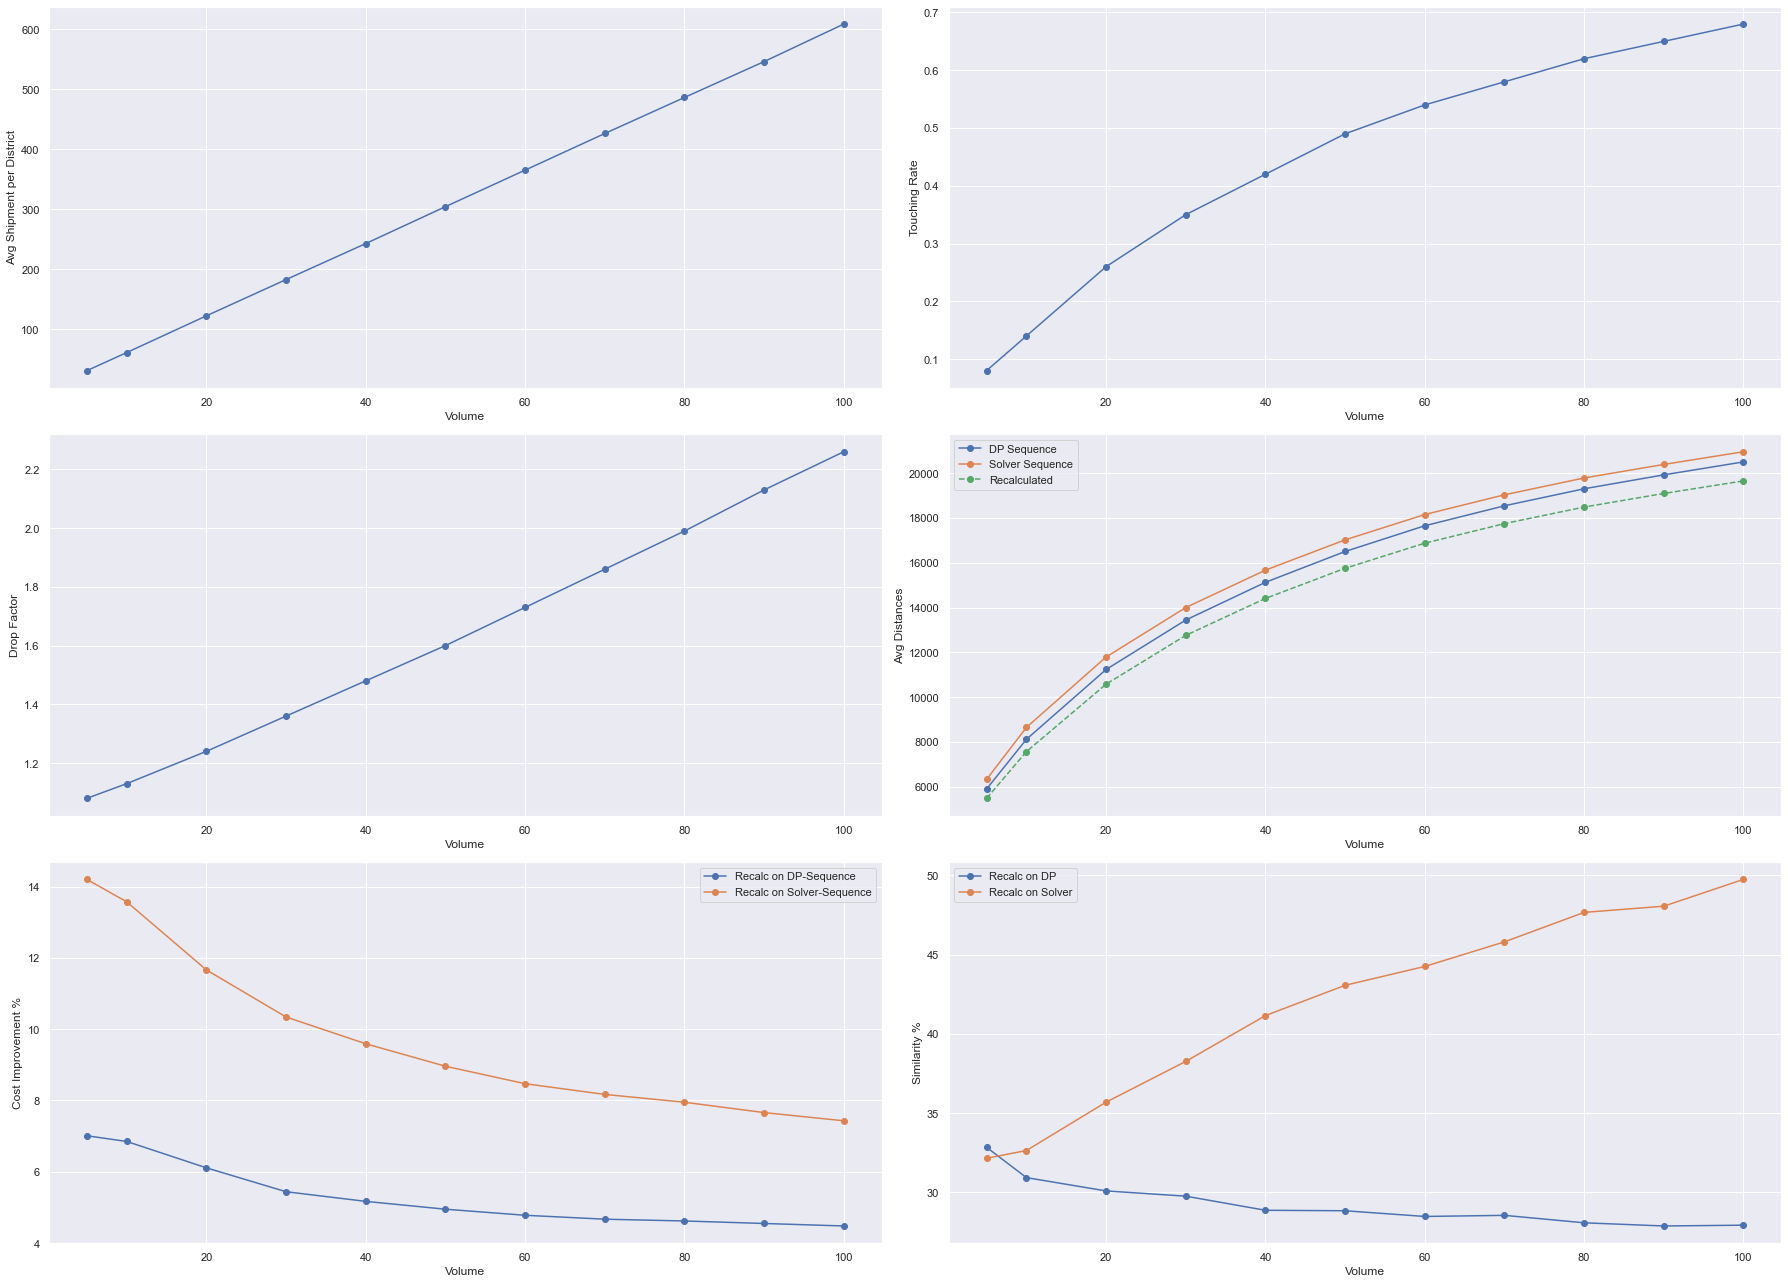

In [113]:
#Plotting Function Example for Warsem data
KPI_region_equal_plots(Warmsen_equal_KPI)

#### Computing for EQUAL Shipment Hannover 92 (URBAN)

In [119]:
%%time

#EXAMPLE OF COMPUTING THE KPI TABLE FOR ONE REGION
Hannover92_equal_KPI = pipeline_statistics_region(path_csv_files = path_samples_equal, path_KPI_storage = path_storage_equal, specific_region = 'Hannover_92')

Hannover92_equal_KPI

CPU times: total: 1.61 s
Wall time: 7.26 s


,Shipment Level,Avg Shipment per district,Touching Rate,Drop Factor,Avg Distance DP,Avg Distance Solver,Avg Distance Recalc,Cost Improvement % Recalc vs DP,Cost Improvement % Recalc vs Solver,Similarity % Solver/DP,Similarity % Recalc/DP,Similarity % Recalc/Solver
0,5,70.63,0.14,1.26,4551.53,4303.56,4085.6,10.79,5.11,37.18,34.38,37.29
1,10,142.5,0.25,1.41,5829.36,5529.15,5318.93,9.38,3.98,37.43,34.6,38.03
2,20,283.94,0.38,1.75,7363.61,7018.48,6831.64,8.08,3.13,38.34,35.45,39.26
3,30,425.62,0.47,2.09,8344.01,7975.93,7809.42,7.31,2.65,38.95,36.04,39.83
4,40,567.24,0.53,2.43,9060.29,8664.66,8517.4,6.87,2.28,39.24,36.61,40.65
5,50,709.77,0.58,2.76,9611.73,9202.38,9064.48,6.59,2.07,39.51,37.33,41.86
6,60,851.54,0.62,3.09,10062.27,9637.03,9509.28,6.35,1.89,39.73,37.73,42.47
7,70,994.58,0.66,3.43,10439.12,10005.27,9885.56,6.15,1.77,39.77,37.71,42.84
8,80,1135.83,0.69,3.76,10757.23,10310.32,10195.35,6.03,1.65,39.99,38.01,43.94
9,90,1278.48,0.71,4.09,11026.88,10573.28,10463.36,5.87,1.54,40.08,38.02,44.29


In [120]:
#Read the amount of pickle files in storage path just to review if it used them and created it with its value for each N on a pickle file. 

path_storage_test = os.path.join(path_storage_equal, 'Hannover_92_KPI_Samples')

def count_files(directory):
    file_count = 0
    
    # Iterate over all items in the directory
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        
        # Check if the item is a file
        if os.path.isfile(item_path):
            file_count += 1
    
    return file_count


num_files = count_files(directory = path_storage_test)

print(f"Number of instance files for equal in for Hannover 92: ", num_files)

Number of instance files for equal in for Hannover 92:  990


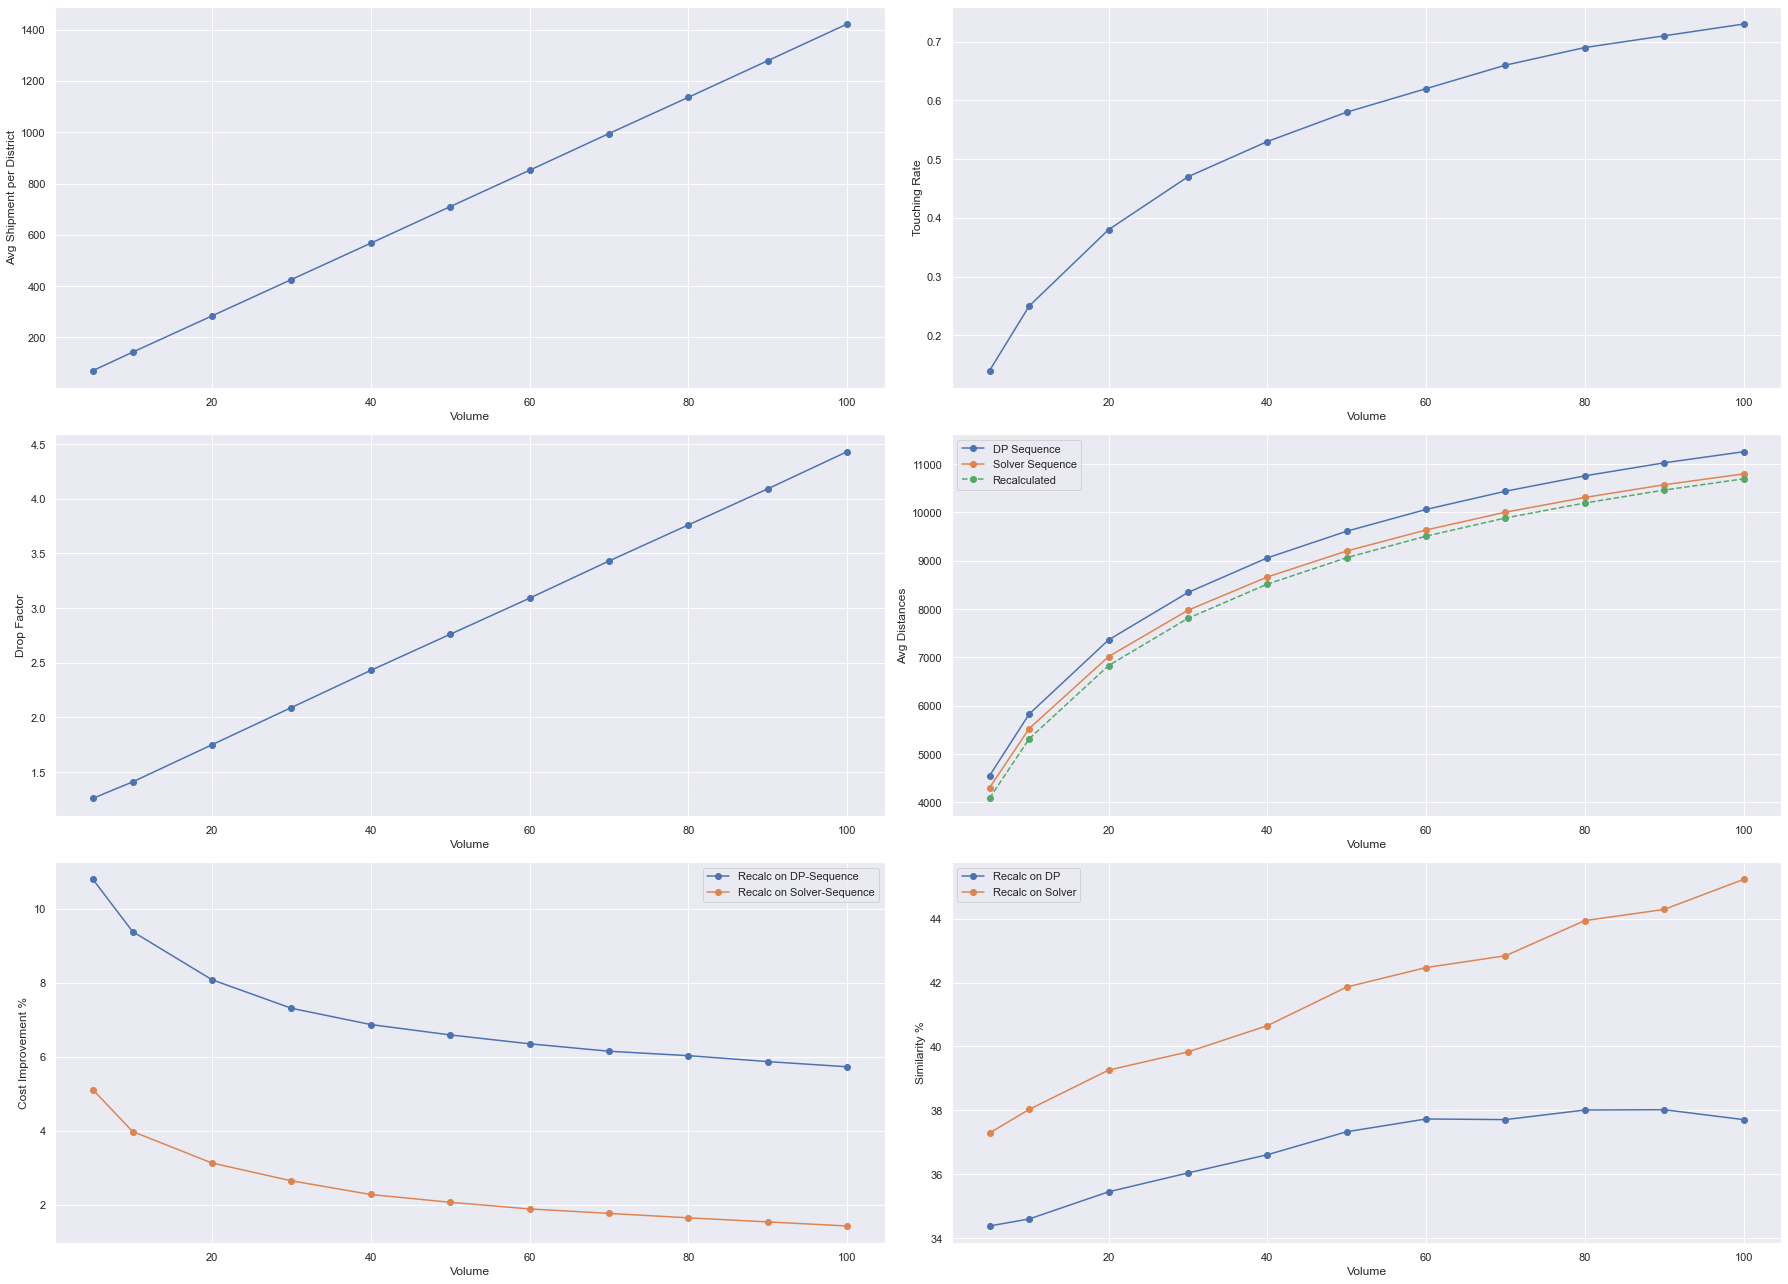

In [121]:
#Plotting Function Example for Hannover data
KPI_region_equal_plots(Hannover92_equal_KPI)

In [ ]:
#Read the amount of pickle files in storage path just to review if it used them and created it with its value for each N on a pickle file. 

path_storage_test = os.path.join(path_storage_equal, 'Warmsen_KPI_Samples')

def count_files(directory):
    file_count = 0
    
    # Iterate over all items in the directory
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        
        # Check if the item is a file
        if os.path.isfile(item_path):
            file_count += 1
    
    return file_count


num_files = count_files(directory = path_storage_test)

print(f"Number of instance files for equal in for Warmsen: ", num_files)

#### Computing for UNEQUAL Shipment WARSEM (RURAL)


In [114]:
%%time

#EXAMPLE OF COMPUTING THE KPI TABLE FOR ONE REGION
Warmsen_unequal_KPI = pipeline_statistics_region(path_csv_files = path_samples_unequal, path_KPI_storage = path_storage_unequal, specific_region = 'Warmsen')

Warmsen_unequal_KPI

CPU times: total: 984 ms
Wall time: 2.7 s


,Shipment Level,Avg Shipment per district,Touching Rate,Drop Factor,Avg Distance DP,Avg Distance Solver,Avg Distance Recalc,Cost Improvement % Recalc vs DP,Cost Improvement % Recalc vs Solver,Similarity % Solver/DP,Similarity % Recalc/DP,Similarity % Recalc/Solver
0,Sce_0,607.92,0.67,2.27,20464.16,20917.75,19617.51,4.45,7.44,28.47,28.09,49.58
1,Sce_1,207.1,0.38,1.44,14252.22,14832.17,13525.78,5.4,10.13,28.19,29.23,40.02
2,Sce_2,458.26,0.6,1.94,19070.12,19558.44,18264.17,4.55,7.84,28.31,28.34,47.04


In [115]:
#Read the amount of pickle files in storage path just to review if it used them and created it with its value for each N on a pickle file. 

path_storage_test = os.path.join(path_storage_unequal, 'Warmsen_KPI_Samples')

def count_files(directory):
    file_count = 0
    
    # Iterate over all items in the directory
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        
        # Check if the item is a file
        if os.path.isfile(item_path):
            file_count += 1
    
    return file_count


num_files = count_files(directory = path_storage_test)

print(f"Number of instance files for unequal in for Warmsen: ", num_files)

Number of instance files for unequal in for Warmsen:  252


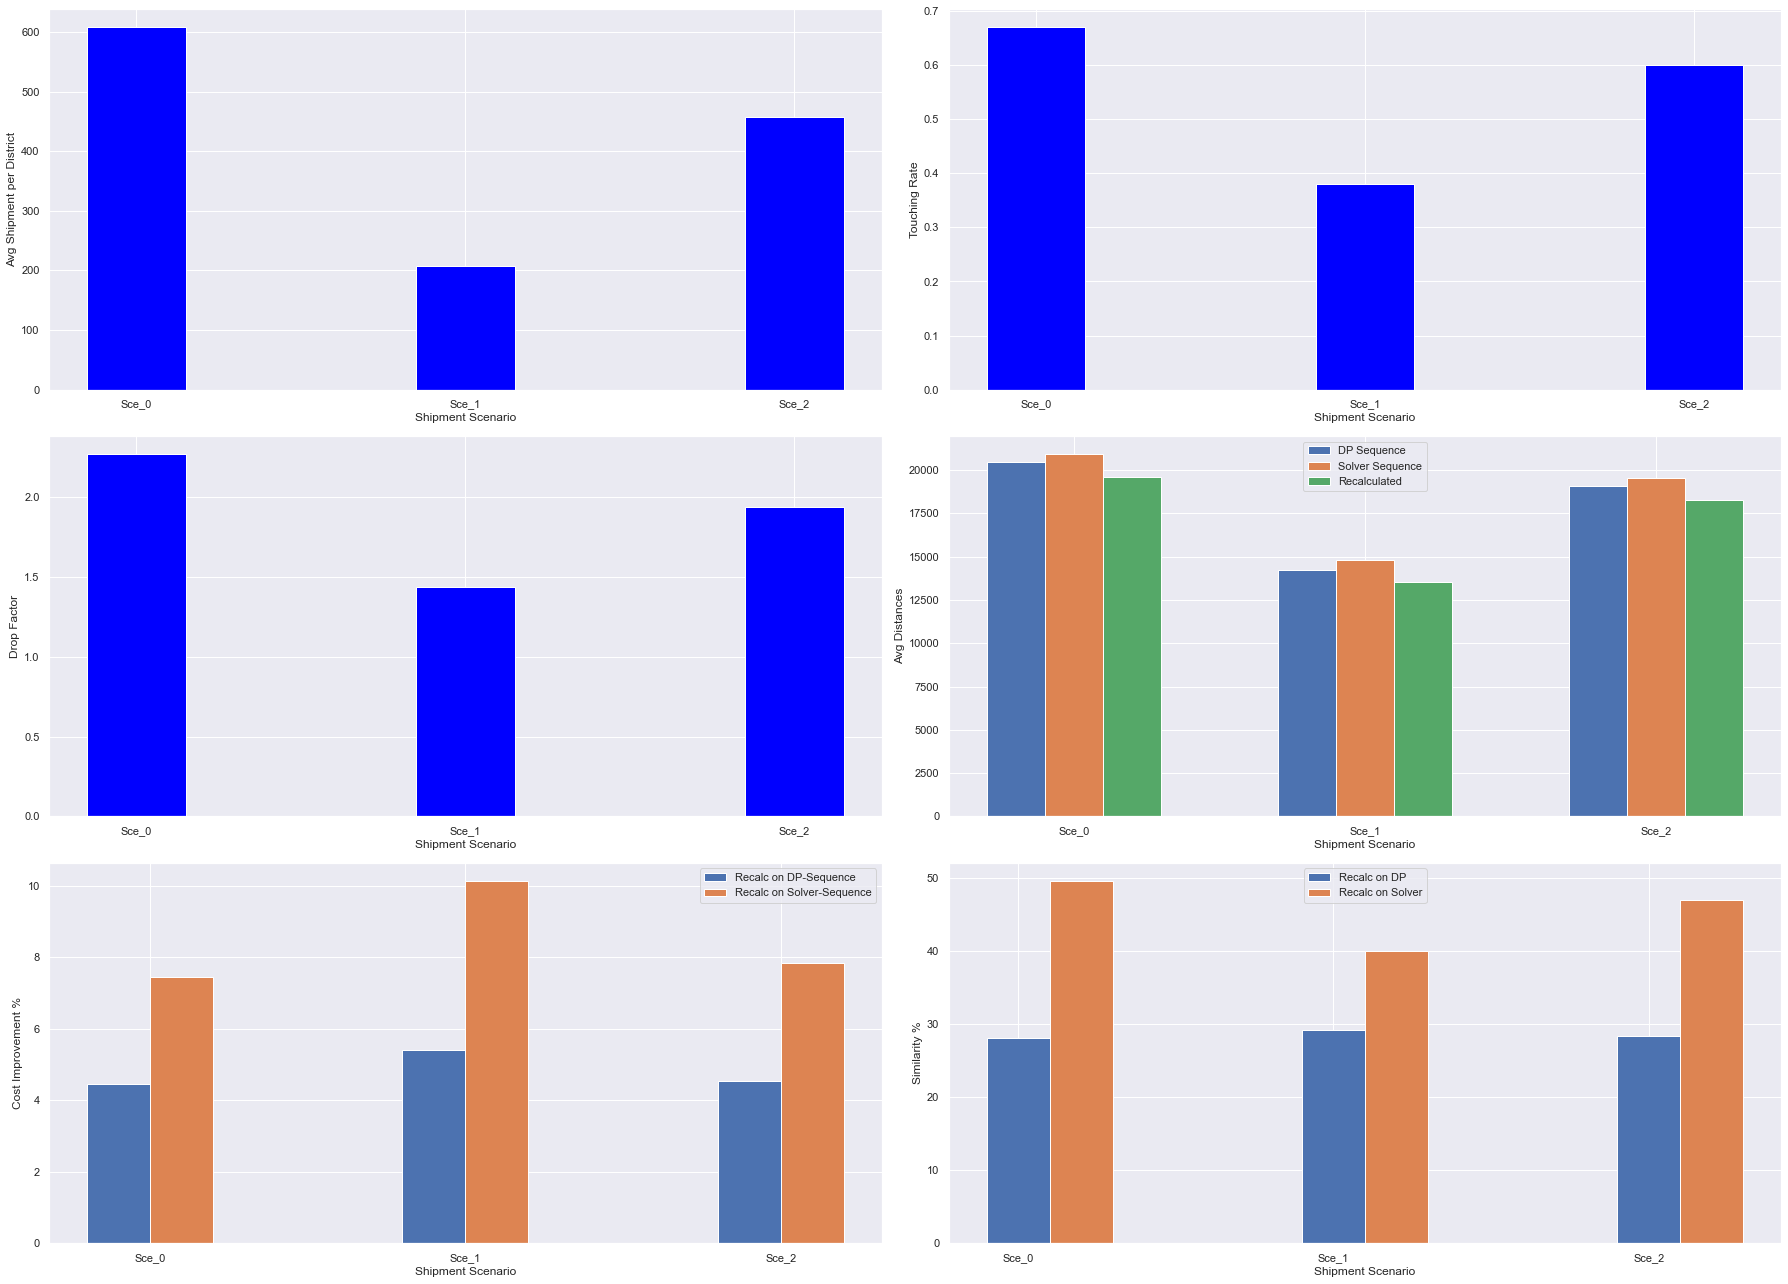

In [116]:
#Plotting Function Example for Warsem data
KPI_region_unequal_plots(Warmsen_unequal_KPI)

#### Computing for UNEQUAL Shipment UERZE (SUBURBAN)


In [124]:
%%time

#EXAMPLE OF COMPUTING THE KPI TABLE FOR ONE REGION
Uerze_unequal_KPI = pipeline_statistics_region(path_csv_files = path_samples_unequal, path_KPI_storage = path_storage_unequal, specific_region = 'Uerze')

Uerze_unequal_KPI

CPU times: total: 594 ms
Wall time: 1.58 s


,Shipment Level,Avg Shipment per district,Touching Rate,Drop Factor,Avg Distance DP,Avg Distance Solver,Avg Distance Recalc,Cost Improvement % Recalc vs DP,Cost Improvement % Recalc vs Solver,Similarity % Solver/DP,Similarity % Recalc/DP,Similarity % Recalc/Solver
0,Sce_0,702.54,0.67,2.25,15493.33,15633.49,14986.05,3.84,4.85,25.48,27.88,45.74
1,Sce_1,250.48,0.39,1.45,10714.41,10947.25,10257.54,4.87,7.0,25.29,29.78,37.6
2,Sce_2,534.88,0.6,1.94,14375.81,14545.0,13880.28,4.02,5.23,25.59,28.29,43.75


In [126]:
#Read the amount of pickle files in storage path just to review if it used them and created it with its value for each N on a pickle file. 

path_storage_test = os.path.join(path_storage_unequal, 'Uerze_KPI_Samples')

def count_files(directory):
    file_count = 0
    
    # Iterate over all items in the directory
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        
        # Check if the item is a file
        if os.path.isfile(item_path):
            file_count += 1
    
    return file_count


num_files = count_files(directory = path_storage_test)

print(f"Number of instance files for unequal in for Uerze: ", num_files)

Number of instance files for unequal in for Uerze:  306


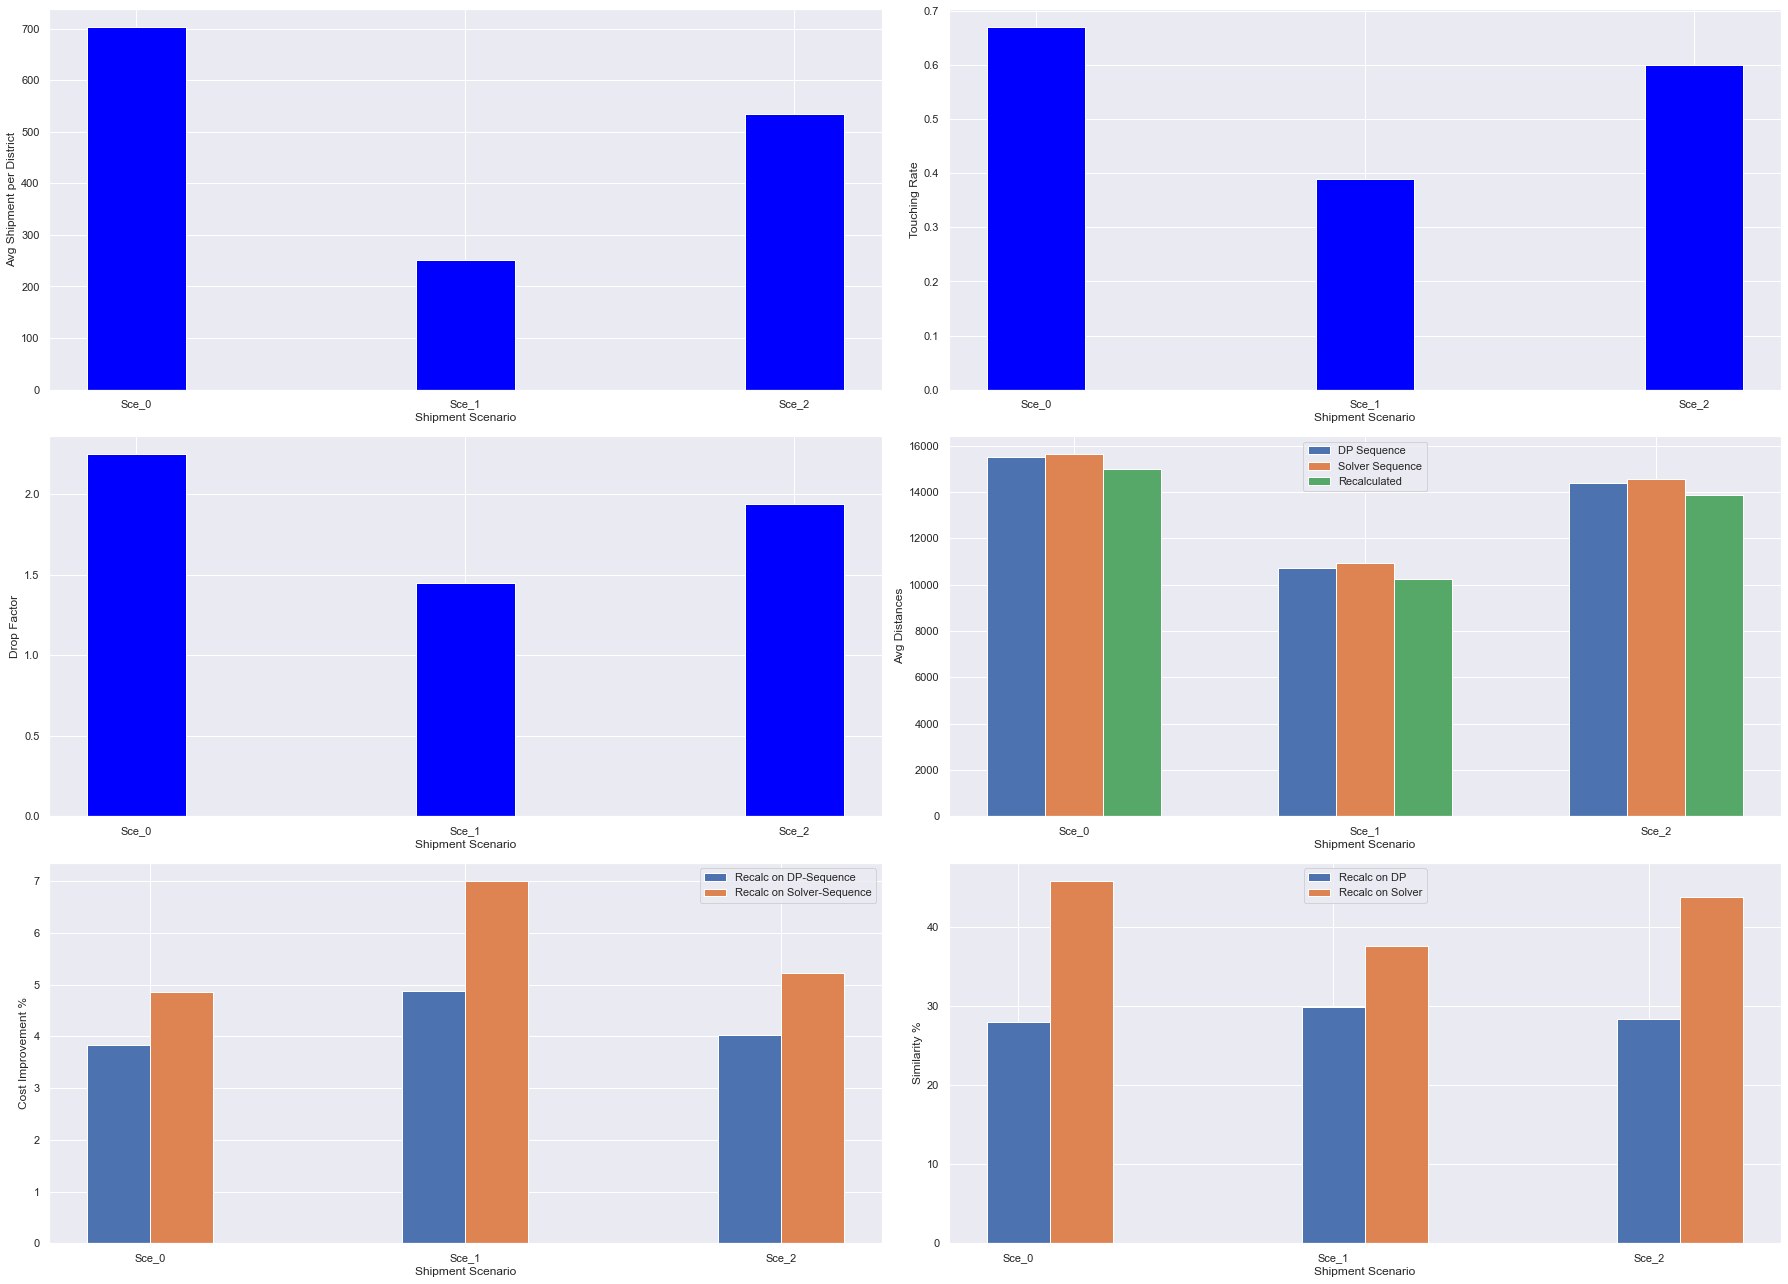

In [127]:
#Plotting Function Example for Warsem data
KPI_region_unequal_plots(Uerze_unequal_KPI)